# Data Information

<p>
Get the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics
1. Mean Absolute Percentage Error.(MAPE)
2. Mean Squared error.


<h2> Assignments.</h2>
#### Task 1 : Incorporate Fourier features as features into Regression models and measure MAPE.[Click Here](#Task1)
#### Task 2 : Perform hyper-parameter tuning for Regression models(Linear Regression, Random Forest, XgBoost). [Click Here](#Task2)
#### Task 3 : Perform Feature Engg to reduce the MAPE to <12%.[Click Here](#Task3)


In [130]:
# Importing Libraries
# pip3 install graphviz
# pip3 install dask
# pip3 install toolz
# pip3 install cloudpickle
# https://www.youtube.com/watch?v=ieW3G7ZzRZ0
# https://github.com/dask/dask-tutorial
# please do go through this python notebook: https://github.com/dask/dask-tutorial/blob/master/07_dataframe_storage.ipynb
import dask.dataframe as dd #similar to pandas

import pandas as pd #pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np #Do aritmetic operations on arrays
import scipy
# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocol which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns #Plots
from matplotlib import rcParams #Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [16]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('training/yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [3]:
# table below shows few datapoints along with all our features
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error.<br>
From our EDA in the initial version of the case study, we found the following:<br>
1. <b>Pickup/Drop-off Latitude and Longitude</b> : New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004), hence any cordinates not within these cordinates are not considered by us.
2. <b>Trip Durations</b> : According to NYC Taxi &amp; Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.
3. <b>Speed</b> : We found that 99.9th percentile value of speed is 45.31 mph and also that the avg speed in New York is 12.45miles/hr, so a cab driver can travel  2 miles per 10min on avg
4. <b>Trip Distance</b> : The 99.9th percentile value of the distance covered in a ride is ~23 miles
5. <b>Total Fare</b> : From percentile and graphical analysis, we set the upper limit of total fare to be 1000$

In [4]:
# The timestamps are converted to unix so as to get duration(trip-time) & speed 
# Also pickup-times in unix are used while binning 

# In our data we have time in the format "YYYY-MM-DD HH:MM:SS". We convert this string to python time format 
# and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

## Remove all outliers/erronous points.

In [5]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 45.31) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [6]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 36690
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation
## Clustering/Segmentation
We used GridSearch to find the right K(no of clusters) and found that - <br>
On choosing a <b>cluster size of  40 </b><br>
1. Avg. Number of Clusters within the vicinity            (i.e. intercluster-distance < 2): 8.0 
2. Avg. Number of Clusters            outside the vicinity (i.e. intercluster-distance > 2): 32.0 
3. Min inter-cluster distance =  0.5069768450363973 

In [7]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [8]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

## Time-binning

In [9]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est(5hrs behind gmt)
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [10]:
# making pickup bins and grouping by pickup cluster and pickup bins
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [20]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,34,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,2,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,16,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,38,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,22,1419


In [12]:
# here the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we divide whole months time into 10min intravels 31*24*60/10 = 4464 bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

In [18]:
print(jan_2015_frame.shape)
print(jan_2015_groupby.shape)

(12371076, 12)
(170359, 1)


In [21]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickup_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('training/yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('training/yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('training/yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 31018
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 31866
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

## Smoothing

In [22]:
# Gets the unique bins where pickup values are present for each region

# for each cluster region we will collect all the indices of 10min intravels in which the pickups happened
# we got an observation that there are some pick-up bins that dont have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [23]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [24]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins
# no of 10 min bins in that particular month

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on prev and next values)
# we finally return smoothed data
def fill_missing(count_values,values,bins):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(bins):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [26]:
# Now in smoothing, we are looking at future values(future number of pickups) which might cause a data leakage.
# So we use smoothing for jan 2015 data since it acts as our training data
# and we use simple fill_misssing method for 2016 data.

# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique,4464)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique,4176)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique,4464)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])



In [27]:
print(len(jan_2016_smooth))
print(len(feb_2016_smooth))
print(len(mar_2016_smooth))
print(len(regions_cum))
9print(len(regions_cum[0]))

178560
167040
178560
40
13104


## Time series and Fourier Transforms

<IPython.core.display.Javascript object>


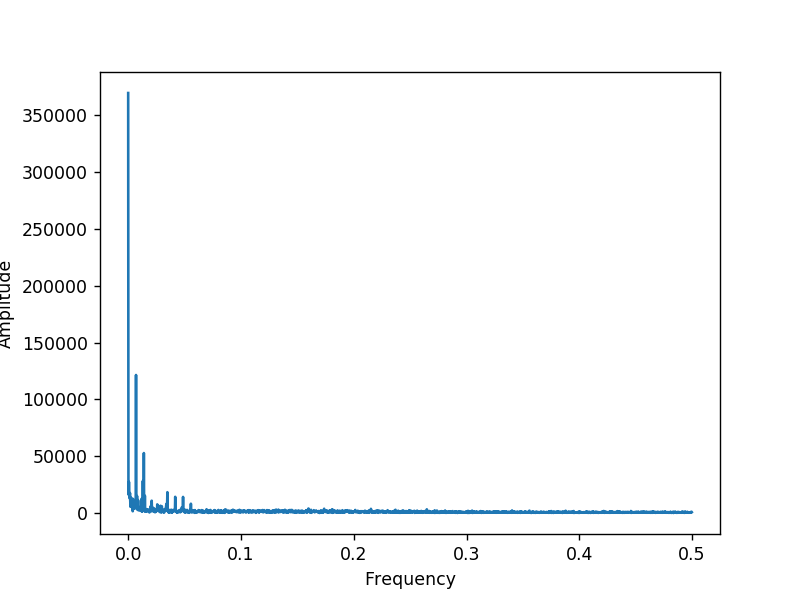

In [28]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

<a id ='Task1'><h2> Now we get the 3 peak amplitudes and corresponding frequencies for our 2016 data</h2></a>

In [103]:
# this method return the top 3 amplitude and frequency for each cluster in a particular month
def getPeakAmpFreq(month_data, noOfBins, month):
    top_amp=[]
    top_freq=[]
    for i in range(0,40):
        amp_cluster = []
        freq_cluster = []
        if(month == 'jan'):
            amp_cluster = np.abs( np.fft.fft(np.array(month_data)[ (noOfBins * i ) +5: noOfBins* (i+1) ]) )
            freq_cluster = np.fft.fftfreq(noOfBins, 1)
        else:
            amp_cluster    = np.abs( np.fft.fft(np.array(month_data)[ (noOfBins *i ): (noOfBins* (i+1)) ]) )
            freq_cluster = np.fft.fftfreq(noOfBins, 1)
        #Get top 5 amp and its frequencies
        top_indices=np.array(np.argsort(amp_cluster)[::-1])[0:3]
        #amp_cluster = [amp_cluster[top_indices]] * noOfBins
        #freq_cluster = [freq_cluster[top_indices]] * noOfBins
        
        amp_cluster = amp_cluster[top_indices]
        freq_cluster = freq_cluster[top_indices]
        
        top_amp.append(amp_cluster)
        top_freq.append(freq_cluster)
    
    return top_amp,top_freq

In [104]:
jan_2016_topAmp,jan_2016_topFreq = getPeakAmpFreq(jan_2016_smooth,4464,'jan')
feb_2016_topAmp,feb_2016_topFreq = getPeakAmpFreq(feb_2016_smooth,4176,'feb')
mar_2016_topAmp,mar_2016_topFreq = getPeakAmpFreq(mar_2016_smooth,4464,'mar')

In [105]:
# Now we stitch the data obtained above such that we have the peak amp and freq for all time-bins(jan+feb+mar) in a cluster
amp_1 = []; amp_2 = []; amp_3 = []; amp_4 = []; amp_5 = []
freq_1 = []; freq_2 = []; freq_3 = []; freq_4 = []; freq_5 = []

for i in range(40):
    amp_1.append([jan_2016_topAmp[i][0]] * 4459 + [feb_2016_topAmp[i][0]] * 4176 + [mar_2016_topAmp[i][0]] * 4464)
    amp_2.append([jan_2016_topAmp[i][1]] * 4459 + [feb_2016_topAmp[i][1]] * 4176 + [mar_2016_topAmp[i][1]] * 4464)
    amp_3.append([jan_2016_topAmp[i][2]] * 4459 + [feb_2016_topAmp[i][2]] * 4176 + [mar_2016_topAmp[i][2]] * 4464)
    #amp_4.append([jan_2016_topAmp[i][3]] * 4459 + [feb_2016_topAmp[i][3]] * 4176 + [mar_2016_topAmp[i][3]] * 4464)
    #amp_5.append([jan_2016_topAmp[i][4]] * 4459 + [feb_2016_topAmp[i][4]] * 4176 + [mar_2016_topAmp[i][4]] * 4464)
    
    freq_1.append([jan_2016_topFreq[i][0]] * 4459 + [feb_2016_topFreq[i][0]] * 4176 + [mar_2016_topFreq[i][0]] * 4464)
    freq_2.append([jan_2016_topFreq[i][1]] * 4459 + [feb_2016_topFreq[i][1]] * 4176 + [mar_2016_topFreq[i][1]] * 4464)
    freq_3.append([jan_2016_topFreq[i][2]] * 4459 + [feb_2016_topFreq[i][2]] * 4176 + [mar_2016_topFreq[i][2]] * 4464)
    #freq_4.append([jan_2016_topFreq[i][3]] * 4459 + [feb_2016_topFreq[i][3]] * 4176 + [mar_2016_topFreq[i][3]] * 4464)
    #freq_5.append([jan_2016_topFreq[i][4]] * 4459 + [feb_2016_topFreq[i][4]] * 4176 + [mar_2016_topFreq[i][4]] * 4464)


## Feature preparation

In [106]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split 
# into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that happened for the 1st three months of 2016


# we take the number of pickups that happened in the last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times latitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its a numpy array, of shape (523960, 5)
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups 
    # that happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists 
    # [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] 
                                             for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

print(len(tsne_lat), len(tsne_lat[0]))
print(len(tsne_weekday),len(tsne_weekday[0]))
print(len(tsne_feature),len(tsne_feature[0]))

40 13099
40 13099
523960 5


In [107]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]
    
print(len(predict_list),len(predict_list[0]))

40 13099


### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [108]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [109]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) of each cluster for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# extract the rest 30% for test data
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

print("Number of data clusters",len(train_features), "Number of data points in train data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")

Number of data clusters 40 Number of data points in train data 9169 Each data point contains 5 features


In [110]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

# extracting the rest of the timestamp values i.e 30% of 13099 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [111]:
# the above contains values in the form of list of lists (i.e. list of values of each region), 
# here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [112]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [113]:
# split(train-test) the fourier features too
tsne_train_flat_amp_1 = [i[:9169] for i in amp_1]
tsne_train_flat_amp_2 = [i[:9169] for i in amp_2]
tsne_train_flat_amp_3 = [i[:9169] for i in amp_3]
#tsne_train_flat_amp_4 = [i[:9169] for i in amp_4]
#tsne_train_flat_amp_5 = [i[:9169] for i in amp_5]

tsne_test_flat_amp_1 = [i[9169:] for i in amp_1]
tsne_test_flat_amp_2 = [i[9169:] for i in amp_2]
tsne_test_flat_amp_3 = [i[9169:] for i in amp_3]
#tsne_test_flat_amp_4 = [i[9169:] for i in amp_4]
#tsne_test_flat_amp_5 = [i[9169:] for i in amp_5]

tsne_train_flat_freq_1 = [i[:9169] for i in freq_1]
tsne_train_flat_freq_2 = [i[:9169] for i in freq_2]
tsne_train_flat_freq_3 = [i[:9169] for i in freq_3]
#tsne_train_flat_freq_4 = [i[:9169] for i in freq_4]
#tsne_train_flat_freq_5 = [i[:9169] for i in freq_5]

tsne_test_flat_freq_1 = [i[9169:] for i in freq_1]
tsne_test_flat_freq_2 = [i[9169:] for i in freq_2]
tsne_test_flat_freq_3 = [i[9169:] for i in freq_3]
#tsne_test_flat_freq_4 = [i[9169:] for i in freq_4]
#tsne_test_flat_freq_5 = [i[9169:] for i in freq_5]


In [114]:
# converting list of lists into sinle list i.e flatten
tsne_train_amp_1 = sum(tsne_train_flat_amp_1, [])
tsne_train_amp_2 = sum(tsne_train_flat_amp_2, [])
tsne_train_amp_3 = sum(tsne_train_flat_amp_3, [])
#tsne_train_amp_4 = sum(tsne_train_flat_amp_4, [])
#tsne_train_amp_5 = sum(tsne_train_flat_amp_5, [])

tsne_train_freq_1 = sum(tsne_train_flat_freq_1, [])
tsne_train_freq_2 = sum(tsne_train_flat_freq_2, [])
tsne_train_freq_3 = sum(tsne_train_flat_freq_3, [])
#tsne_train_freq_4 = sum(tsne_train_flat_freq_4, [])
#tsne_train_freq_5 = sum(tsne_train_flat_freq_5, [])

#flatten the test data
tsne_test_amp_1 = sum(tsne_test_flat_amp_1, [])
tsne_test_amp_2 = sum(tsne_test_flat_amp_2, [])
tsne_test_amp_3 = sum(tsne_test_flat_amp_3, [])
#tsne_test_amp_4 = sum(tsne_test_flat_amp_4, [])
#tsne_test_amp_5 = sum(tsne_test_flat_amp_5, [])

tsne_test_freq_1 = sum(tsne_test_flat_freq_1, [])
tsne_test_freq_2 = sum(tsne_test_flat_freq_2, [])
tsne_test_freq_3 = sum(tsne_test_flat_freq_3, [])
#tsne_test_freq_4 = sum(tsne_test_flat_freq_4, [])
#tsne_test_freq_5 = sum(tsne_test_flat_freq_5, [])

In [115]:
# this method is used to standardize the features
def standardizeValues(val,std):
    if std == 'Y':
        z = np.array(val)
        z = z.reshape(-1,1) # turns a 1-d array into 2-d array
        std = StandardScaler().fit_transform(z)
        return std
    else:
        return val

### Preparing the data frame for train and test data

In [204]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

df_train['amp_1'] = standardizeValues(tsne_train_amp_1,'Y')
df_train['amp_2'] = standardizeValues(tsne_train_amp_2,'Y')
df_train['amp_3'] = standardizeValues(tsne_train_amp_3,'Y')
#df_train['amp_4'] = standardizeValues(tsne_train_amp_4,'Y')
#df_train['amp_5'] = standardizeValues(tsne_train_amp_5,'Y')
df_train['freq_1'] = standardizeValues(tsne_train_freq_1,'Y')
df_train['freq_2'] = standardizeValues(tsne_train_freq_2,'Y')
df_train['freq_3'] = standardizeValues(tsne_train_freq_3,'Y')
#df_train['freq_4'] = standardizeValues(tsne_train_freq_4,'Y')
#df_train['freq_5'] = standardizeValues(tsne_train_freq_5,'Y')

print(df_train.shape)

(366760, 15)


In [205]:
# Preparing the data frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg

df_test['amp_1'] = standardizeValues(tsne_test_amp_1,'Y')
df_test['amp_2'] = standardizeValues(tsne_test_amp_2,'Y')
df_test['amp_3'] = standardizeValues(tsne_test_amp_3,'Y')
#df_test['amp_4'] = standardizeValues(tsne_test_amp_4,'Y')
#df_test['amp_5'] = standardizeValues(tsne_test_amp_5,'Y')
df_test['freq_1'] = standardizeValues(tsne_test_freq_1,'Y')
df_test['freq_2'] = standardizeValues(tsne_test_freq_2,'Y')
df_test['freq_3'] = standardizeValues(tsne_test_freq_3,'Y')
#df_test['freq_4'] = standardizeValues(tsne_test_freq_4,'Y')
#df_test['freq_5'] = standardizeValues(tsne_test_freq_5,'Y')

print(df_test.shape)

(157200, 15)


<h1> Applying Regression Models With Fourier Features </h1>

<a id ='Task2'><h2> Hyperparameter tuning for regression models</h2></a>

In [206]:
# Error Function To Be Used In GridSearchCV and RandomSearchCV 
from sklearn.metrics.scorer import make_scorer

def myError(y_orig,y_pred):
    error=mean_absolute_error(y_orig, y_pred)/(sum(y_orig)/len(y_orig))
    return error

my_scorer = make_scorer(myError, greater_is_better=False)

<h3> Linear Regression </h3>

In [207]:
tuned_parameters = [{'alpha': [0.001,0.01,0.1,1,10] , 'eta0': [10 ** -4,10 ** -5,10 ** -6,10 ** -7,10 ** -8,10 ** -9,10 ** -10]}]
gridSearchModel = GridSearchCV(SGDRegressor(random_state=42,loss='squared_loss',penalty='l2'),tuned_parameters,scoring = my_scorer, cv=5)
gridSearchModel.fit(df_train, tsne_train_output)
results = gridSearchModel.cv_results_

In [208]:
print('Best estimator :{}'.format(gridSearchModel.best_estimator_))
print('\nScore on train data :{}'.format(np.abs(gridSearchModel.score(df_train, tsne_train_output))))
print('\nScore on test data :{}'.format(np.abs(gridSearchModel.score(df_test, tsne_test_output))))

Best estimator :SGDRegressor(alpha=1, average=False, epsilon=0.1, eta0=1e-06,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

Score on train data :0.13328126815566635

Score on test data :0.1294854274103974


<h4> Training the model with best hyper params </h4>

In [210]:
bestAlpha = gridSearchModel.best_estimator_.alpha
bestEta = gridSearchModel.best_estimator_.eta0

clf = SGDRegressor(random_state=42,loss='squared_loss',penalty='l2',alpha=bestAlpha, eta0=bestEta)
clf.fit(df_train,tsne_train_output)

y_pred = clf.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = clf.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

# print some predicted values for both train and test data-sets
print(lr_train_predictions[0:10])
print(tsne_train_output[0:10])
print("*" * 50)
print(lr_test_predictions[0:10])
print(tsne_test_output[0:10])

[154.0, 142.0, 129.0, 141.0, 156.0, 152.0, 137.0, 136.0, 142.0, 130.0]
[135, 129, 150, 164, 152, 131, 138, 147, 127, 138]
**************************************************
[99.0, 99.0, 113.0, 124.0, 151.0, 152.0, 139.0, 144.0, 161.0, 154.0]
[101, 120, 131, 164, 154, 133, 148, 172, 153, 162]


### Random Forest Regressor

In [211]:
min_samples_leaf = np.random.uniform(2, 80, 3).astype(int)
min_samples_split = np.random.uniform(2, 10, 3).astype(int)
n_estimators = np.random.uniform(20, 80 ,3).astype(int)

tuned_parameters = {'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'n_estimators': n_estimators}
rndSearchRF = RandomizedSearchCV(RandomForestRegressor(max_features='sqrt'),tuned_parameters,scoring = my_scorer, cv=5)
rndSearchRF.fit(df_train, tsne_train_output)
results = rndSearchRF.cv_results_

In [212]:
print('Best estimator :{}'.format(rndSearchRF.best_estimator_))
print('\nScore on train data :{}'.format(np.abs(rndSearchRF.score(df_train, tsne_train_output))))
print('\nScore on test data :{}'.format(np.abs(rndSearchRF.score(df_test, tsne_test_output))))

Best estimator :RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=40, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=62, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Score on train data :0.12401837056979532

Score on test data :0.1252903096962737


<h4> Training the model with best hyper params </h4>

In [213]:
# get the best value of hyperparams that we obtained from random search
bestMinSampleLeaf = rndSearchRF.best_estimator_.min_samples_leaf
bestSplit = rndSearchRF.best_estimator_.min_samples_split
bestEstimators = rndSearchRF.best_estimator_.n_estimators

# train the model
rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf=bestMinSampleLeaf, min_samples_split=bestSplit, n_estimators=bestEstimators)
rf.fit(df_train,tsne_train_output)

y_pred = rf.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = rf.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

# print some predicted values for both train and test data-sets
print(rndf_train_predictions[0:10])
print(tsne_train_output[0:10])
print("*" * 50)
print(rndf_test_predictions[0:10])
print(tsne_test_output[0:10],"\n")

# feature importances based on analysis using random forest
top_feat_indices = np.argsort(rf.feature_importances_)[::-1]
#print the features in desc order of FI
print(df_train.columns[top_feat_indices]) 

[133.0, 136.0, 131.0, 140.0, 153.0, 147.0, 140.0, 137.0, 140.0, 132.0]
[135, 129, 150, 164, 152, 131, 138, 147, 127, 138]
**************************************************
[102.0, 103.0, 113.0, 125.0, 151.0, 147.0, 138.0, 142.0, 156.0, 151.0]
[101, 120, 131, 164, 154, 133, 148, 172, 153, 162] 

Index(['exp_avg', 'ft_1', 'ft_2', 'ft_3', 'ft_4', 'ft_5', 'amp_3', 'amp_1',
       'amp_2', 'lat', 'lon', 'weekday', 'freq_2', 'freq_3', 'freq_1'],
      dtype='object')


### XgBoost Regressor

In [140]:
min_child_weight = np.random.uniform(2, 8, 2).astype(int)
max_depth = np.random.uniform(2, 8, 2).astype(int)
n_estimators = np.random.uniform(100, 1000 ,2).astype(int)
reg_alpha = np.random.uniform(100, 500 ,2).astype(int)
reg_lambda = np.random.uniform(100, 500 ,2).astype(int)

tuned_parameters = {
    'min_child_weight':min_child_weight,
    'max_depth':max_depth,
    'n_estimators': n_estimators,
    'reg_alpha':reg_alpha,
    'reg_lambda': reg_lambda
}

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4)

xgbModelRS = RandomizedSearchCV(x_model,param_distributions=tuned_parameters,scoring = my_scorer, cv=5)
xgbModelRS.fit(df_train,tsne_train_output)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'min_child_weight': array([2, 2]), 'max_depth': array([7, 3]), 'n_estimators': array([238, 206]), 'reg_alpha': array([469, 356]), 'reg_lambda': array([252, 298])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(myError, greater_is_better=False), verbose=0)

In [214]:
print('Best estimator :{}'.format(xgbModelRS.best_estimator_))
print('\nScore on train data :{}'.format(np.abs(xgbModelRS.score(df_train, tsne_train_output))))
print('\nScore on test data :{}'.format(np.abs(xgbModelRS.score(df_test, tsne_test_output))))

Best estimator :XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=2, missing=None, n_estimators=238,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=469, reg_lambda=252, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Score on train data :0.1262847620955166

Score on test data :0.12456086568243831


<h4> Training the model with best hyper params </h4>

In [215]:
# get the best value of hyperparams that we obtained from random search
bestdepth = xgbModelRS.best_estimator_.max_depth
bestChildWeight = xgbModelRS.best_estimator_.min_child_weight
bestEstimators = xgbModelRS.best_estimator_.n_estimators
bestlambda = xgbModelRS.best_estimator_.reg_lambda
bestalpha = xgbModelRS.best_estimator_.reg_alpha

# train the model
xgbBest = xgb.XGBRegressor(
 learning_rate =0.1,
 max_depth=bestdepth,
 min_child_weight = bestChildWeight,
 n_estimators = bestEstimators,
 reg_alpha = bestalpha,
 reg_lambda = bestlambda,   
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,nthread=4)
xgbBest.fit(df_train,tsne_train_output)

y_pred = xgbBest.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = xgbBest.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

# print some predicted values for both train and test data-sets
print(xgb_train_predictions[0:10])
print(tsne_train_output[0:10])
print("*" * 50)
print(xgb_test_predictions[0:10])
print(tsne_test_output[0:10],"\n")

# feature importances based on analysis using random forest
top_feat_indices = np.argsort(xgbBest.feature_importances_)[::-1]
#print the features in desc order of FI
print(df_train.columns[top_feat_indices]) 

[120.0, 129.0, 130.0, 137.0, 153.0, 148.0, 138.0, 137.0, 139.0, 133.0]
[135, 129, 150, 164, 152, 131, 138, 147, 127, 138]
**************************************************
[103.0, 103.0, 114.0, 122.0, 150.0, 148.0, 139.0, 141.0, 153.0, 151.0]
[101, 120, 131, 164, 154, 133, 148, 172, 153, 162] 

Index(['ft_5', 'ft_1', 'ft_2', 'ft_3', 'exp_avg', 'ft_4', 'amp_1', 'weekday',
       'lon', 'amp_2', 'lat', 'amp_3', 'freq_2', 'freq_3', 'freq_1'],
      dtype='object')


### Calculating the error metric values for various models

In [216]:
# MAPE : Mean Absolute Percentage Error
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output, df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [217]:
# MSE : Mean Squared Error
from math import sqrt
train_rmse=[]
test_rmse=[]

train_rmse.append((mean_squared_error(tsne_train_output,df_train['ft_1'].values)))
train_rmse.append((mean_squared_error(tsne_train_output,df_train['exp_avg'].values)))
train_rmse.append((mean_squared_error(tsne_train_output,rndf_train_predictions)))
train_rmse.append((mean_squared_error(tsne_train_output,xgb_train_predictions)))
train_rmse.append((mean_squared_error(tsne_train_output,lr_train_predictions)))

test_rmse.append((mean_squared_error(tsne_test_output,df_test['ft_1'].values)))
test_rmse.append((mean_squared_error(tsne_test_output,df_test['exp_avg'].values)))
test_rmse.append((mean_squared_error(tsne_test_output,rndf_test_predictions)))
test_rmse.append((mean_squared_error(tsne_test_output,xgb_test_predictions)))
test_rmse.append((mean_squared_error(tsne_test_output,lr_test_predictions)))

### Error Metric Matrix

In [218]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"       Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                          Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"      Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Error Metric Matrix (Tree Based Regression Methods) -  MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_rmse[0],"      Test: ",test_rmse[0])
print ("Exponential Averages Forecasting -           Train: ",train_rmse[1],"      Test: ",test_rmse[1])
print ("Linear Regression -                          Train: ",train_rmse[4],"      Test: ",test_rmse[4])
print ("Random Forest Regression -                   Train: ",train_rmse[2],"      Test: ",test_rmse[2])
print ("XgBoost Regression -                         Train: ",train_rmse[3],"      Test: ",test_rmse[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.1401984608732528        Test:  0.13653125704827038
Exponential Averages Forecasting -           Train:  0.13289004272580374       Test:  0.12936180420430524
Linear Regression -                          Train:  0.13315413406450863       Test:  0.12939123969280053
Random Forest Regression -                   Train:  0.12388417295150352       Test:  0.1252008876520037
XgBoost Regression -                         Train:  0.12616177668942236       Test:  0.12445974410238962
--------------------------------------------------------------------------------------------------------
Error Metric Matrix (Tree Based Regression Methods) -  MSE
--------------------------------------------------------------------------------------------------------
Baseline Model -                     

<a id ='Task3'><h2> Experiment with feature engg and reduce the MAPE to less than 12% </h2></a>

We tried with quite a few new features, combination of features and also ensemble models(RF+XgBoost--Lr Reg)
and after all this analysis found that <b>hourOfDay</b>(0-23) adds value to our model as it helps the model understand 
peak/imp timings of the day with high pickups. We added hourOfDay as new feature in our data-frame and then used
our best model - Random Forest - to achieve a MAPE of < 12%

In [221]:
# Now we construct a new feature hourOfDay(0-23) and add it to our data frame as a feature
# In a day there are (24*60)/10 = 144 10-min bins 
# For Jan/Mar there are 31*144 = 4464 bins and for Feb there is 29*144 = 4176 bins
# For each region(considering Jan-Mar data there are 4464+4176+4464 = 13104 bins)

hourOFDay_final = [] # list containing the hour(0-23) of each day for the months of Jan-Mar for each cluster sequentially
hourOfEachDay = [] # list of size 144 depicting the corresponding hour to which each 10 min bin belongs
for i in range(24):
    hourOfEachDay.extend([i]*6)

# this list will contain the corr hour for each region i.e for each 10 min time bin of Jan-Mar 
hourOfDay_eachRegion = hourOfEachDay*31 +  hourOfEachDay*29 + hourOfEachDay*31 

# we remove the the 1st 5 entries as those will be used as features
hourOfDay_eachRegion = hourOfDay_eachRegion[5:]

# list containing the hourOfDay for each region for Jan-Mar 10min time bins
for i in  range(40):
    hourOFDay_final.append(hourOfDay_eachRegion)


In [223]:
tsne_train_flat_hourOfDay = [i[:9169] for i in hourOFDay_final]
tsne_test_flat_hourOfDay = [i[9169:] for i in hourOFDay_final]
print(len(tsne_train_flat_hourOfDay), len(tsne_train_flat_hourOfDay[0]), len(tsne_test_flat_hourOfDay[0]))

tsne_train_hourOfDay = sum(tsne_train_flat_hourOfDay, [])
tsne_test_hourOfDay = sum(tsne_test_flat_hourOfDay, [])
print(len(tsne_train_hourOfDay), len(tsne_test_hourOfDay))

40 9169 3930
366760 157200


In [219]:
# train data-frame before adding the new feature
df_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,amp_1,amp_2,amp_3,freq_1,freq_2,freq_3
0,0,63,217,189,137,40.776228,-73.982119,4,150,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356
1,63,217,189,137,135,40.776228,-73.982119,4,139,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356
2,217,189,137,135,129,40.776228,-73.982119,4,132,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356
3,189,137,135,129,150,40.776228,-73.982119,4,144,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356
4,137,135,129,150,164,40.776228,-73.982119,4,158,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356


In [224]:
df_train['hour_of_day'] = tsne_train_hourOfDay
df_test['hour_of_day'] = tsne_test_hourOfDay
print(df_train.shape)
# train data-frame after adding the new feature
df_train.head()

(366760, 16)


,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,amp_1,amp_2,amp_3,freq_1,freq_2,freq_3,hour_of_day
0,0,63,217,189,137,40.776228,-73.982119,4,150,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356,0
1,63,217,189,137,135,40.776228,-73.982119,4,139,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356,1
2,217,189,137,135,129,40.776228,-73.982119,4,132,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356,1
3,189,137,135,129,150,40.776228,-73.982119,4,144,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356,1
4,137,135,129,150,164,40.776228,-73.982119,4,158,0.542451,0.80106,0.80106,0.0,-0.488727,0.401356,1


In [236]:
# train the model using the hyperparams obtained above
# min_samples_leaf = 10, min_samples_split = 3, n_estimators = 52
rf_new = RandomForestRegressor(max_features='sqrt',min_samples_leaf=10,min_samples_split=3,n_estimators=52, n_jobs=-1)
rf_new.fit(df_train, tsne_train_output)

y_pred = rf_new.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = rf_new.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

top_feat_indices = np.argsort(rf_new.feature_importances_)[::-1]
#print the features in desc order of FI
print(df_train.columns[top_feat_indices]) 

Index(['exp_avg', 'ft_1', 'ft_2', 'ft_4', 'ft_3', 'amp_1', 'ft_5', 'amp_3',
       'amp_2', 'hour_of_day', 'lon', 'weekday', 'lat', 'freq_2', 'freq_3',
       'freq_1'],
      dtype='object')


In [238]:
print("Train MAPE: ",(mean_absolute_error(tsne_train_output, rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
print("Test MAPE: ", (mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
print("Train MSE: ", mean_squared_error(tsne_train_output, rndf_train_predictions))
print("Test MSE: ", mean_squared_error(tsne_test_output, rndf_test_predictions))

Train MAPE:  0.10474326753310106
Test MAPE:  0.11840960437938905
Train MSE:  105.61965863234813
Test MSE:  153.3756106870229


### Observation:
We were able to successfully reduce both MAPE(to < 12%) and MSE after adding this new feature